In [ ]:
# this is largely based on the tutorials at: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
# settings
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 60, 'n_steps_out': 30, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")


In [4]:
# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [9]:
# split sequences function, splits multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find end of patterns
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check to see if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input, output parts of the pattern
        # slightly guessing here on how to combine these two examples
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# minmax all data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_df.values)

In [6]:
# split into test/train data sets

# splitting test/training data
data_size = len(scaled)

# using a 90/10 train/test split
training_data = scaled[:(int(data_size * model_settings['train_test_ratio']))]
test_data = scaled[(int(data_size * model_settings['train_test_ratio'])):]

In [7]:
# testing data sets to see if they're correct
training_data

array([[0.71568631, 0.19893428, 0.00884956, ..., 0.10026585, 0.71584037,
        0.50853241],
       [0.61437913, 0.1918295 , 0.00884956, ..., 0.10064564, 0.7339782 ,
        0.49658699],
       [0.57189544, 0.19597397, 0.00884956, ..., 0.09342954, 0.78839176,
        0.47781564],
       ...,
       [0.23202616, 0.11426881, 0.04424779, ..., 0.06152677, 0.16384522,
        0.0887372 ],
       [0.20915033, 0.1089402 , 0.07079646, ..., 0.06988226, 0.14933495,
        0.07337881],
       [0.16993464, 0.09946715, 0.0619469 , ..., 0.0668439 , 0.13422009,
        0.06313991]])

In [8]:
test_data

array([[0.19281047, 0.10420368, 0.0619469 , ..., 0.06190657, 0.13784765,
        0.07167233],
       [0.17973859, 0.10005923, 0.0619469 , ..., 0.06228637, 0.11547764,
        0.06825936],
       [0.21895428, 0.1089402 , 0.0619469 , ..., 0.10748195, 0.14873036,
        0.07252559],
       ...,
       [0.26307192, 0.08170516, 0.00274337, ..., 0.35624762, 0.28470376,
        0.38940271],
       [0.22385623, 0.07845472, 0.00176991, ..., 0.3205469 , 0.29183798,
        0.38907844],
       [0.23529413, 0.07815277, 0.0119469 , ..., 0.34170148, 0.34993953,
        0.41126276]])

In [6]:
minmax = MinMaxScaler(feature_range=(0,1))
columns = [i for i in training_data.columns]
training_data_scaled = minmax.fit_transform(training_data.values)
training_data_scaled = pd.DataFrame(training_data_scaled, columns=columns)
training_data_scaled

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
0,0.715686,0.198934,0.008850,0.145833,0.383743,0.557692,0.281333,1.000000,1.000000,0.482759,...,0.000000,0.182648,0.857143,0.292929,0.523668,0.883117,0.888889,0.996226,0.797844,0.818681
1,0.614379,0.191829,0.008850,0.145833,0.410208,0.512820,0.281333,0.977099,0.977273,0.482759,...,0.000000,0.232877,0.812500,0.267677,0.502828,0.844156,0.888889,1.000000,0.818059,0.799451
2,0.571895,0.195974,0.008850,0.145833,0.429112,0.536325,0.281333,0.954199,0.922727,0.482759,...,0.000000,0.237443,0.830357,0.272727,0.487943,0.840909,0.888889,0.928302,0.878706,0.769231
3,0.506536,0.198342,0.017699,0.145833,0.402647,0.540598,0.260000,1.000000,0.977273,0.344828,...,0.000000,0.232877,0.866071,0.267677,0.374814,0.853896,0.888889,0.928302,0.925876,0.730769
4,0.522876,0.222025,0.017699,0.145833,0.408318,0.536325,0.270667,0.969466,0.913636,0.344828,...,0.000000,0.164384,0.857143,0.257576,0.300387,0.873377,0.888889,0.954717,0.865229,0.662088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.189543,0.124926,0.044248,0.312500,0.591682,0.299145,0.817333,0.358779,0.031818,0.275862,...,0.484131,0.803653,0.473214,0.904040,0.684430,0.337662,0.444444,0.471698,0.167790,0.148352
247,0.254902,0.120782,0.044248,0.354167,0.593573,0.307692,0.834667,0.419847,0.113636,0.275862,...,0.490108,0.867580,0.491071,0.883838,0.827330,0.324675,0.666667,0.600000,0.190027,0.140110
248,0.232026,0.114269,0.044248,0.437500,0.559546,0.314103,0.793333,0.389313,0.068182,0.275862,...,0.460224,0.844749,0.517857,0.873737,0.755880,0.318182,0.777778,0.611321,0.182615,0.142857
249,0.209150,0.108940,0.070796,0.187500,0.514178,0.294872,0.793333,0.343512,0.059091,0.344828,...,0.627578,0.931507,0.535714,0.828283,0.723132,0.256494,0.777778,0.694340,0.166442,0.118132


In [7]:
#df['sum'] = df.sum(axis=1)

# ignore others, working w/ this cell currently

arrays = list()
out_seq = list()
for i in range(len(training_data_scaled)):
    arrays.append(training_data_scaled.iloc[i].to_numpy(dtype=np.float))
'''for i in range(len(training_data)):
    out_seq.append(training_data.iloc[i].sum())
out_seq = np.array(out_seq, dtype=np.float)'''

'for i in range(len(training_data)):\n    out_seq.append(training_data.iloc[i].sum())\nout_seq = np.array(out_seq, dtype=np.float)'

In [18]:
len(arrays[0])

412

In [8]:
# reshape arrays
# in_seq arrays
for i in range(len(arrays)):
    arrays[i] = arrays[i].reshape((len(arrays[i]), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))

In [9]:
# arrays.append(out_seq)
dataset = np.hstack((arrays))

In [12]:
# may just be able to jump right into using the split_sequence func?
X, y = split_sequences(training_data, model_settings['n_steps_in'], model_settings['n_steps_out'])

In [19]:
for i in range(len(y)):
    print(y[i].shape)`

(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)
(30, 251)


In [13]:
n_features = X.shape[2]

In [14]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [15]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(model_settings['n_steps_in'], n_features)))
model.add(RepeatVector(model_settings['n_steps_out']))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
# model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [16]:
# fit model
model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
6/6 [==============================] - 3s 229ms/step - loss: 0.1083
Epoch 2/10
6/6 [==============================] - 1s 239ms/step - loss: 0.0597
Epoch 3/10
6/6 [==============================] - 1s 251ms/step - loss: 0.0328
Epoch 4/10
6/6 [==============================] - 1s 238ms/step - loss: 0.0235
Epoch 5/10
6/6 [==============================] - 1s 242ms/step - loss: 0.0192
Epoch 6/10
6/6 [==============================] - 1s 237ms/step - loss: 0.0161
Epoch 7/10
6/6 [==============================] - 1s 231ms/step - loss: 0.0140
Epoch 8/10
6/6 [==============================] - 1s 237ms/step - loss: 0.0123
Epoch 9/10
6/6 [==============================] - 1s 223ms/step - loss: 0.0112
Epoch 10/10
6/6 [==============================] - 1s 228ms/step - loss: 0.0100


In [ ]:
# reshape all test data to feed to the model
# wait maybe not

In [17]:
# scale test data to test w/ 
# not sure if the model will be able to predict just one symbol's amts moving ahead
#x_input = training_data_scaled.to_numpy()
#x_input = x_input.reshape((1, -1, n_features))
yhat = model.predict(X, verbose=1)
print(yhat)

6/6 [==============================] - 0s 28ms/step
[[[ 0.30811715  0.06333855  0.14176077 ...  0.01971208  0.18685205
    0.10753207]
  [ 0.45343772  0.09260523  0.19570073 ...  0.03961932  0.25747332
    0.1599631 ]
  [ 0.5226152   0.10576838  0.21433546 ...  0.04656483  0.28347808
    0.1865895 ]
  ...
  [ 0.58622587  0.12830639  0.20227475 ...  0.04386971  0.28924182
    0.18509483]
  [ 0.58622825  0.12830617  0.20227602 ...  0.04387153  0.289243
    0.18508627]
  [ 0.5862302   0.1283059   0.2022773  ...  0.04387297  0.28924394
    0.18507999]]

 [[ 0.30991128  0.06438305  0.14550431 ...  0.02051725  0.18798916
    0.10830943]
  [ 0.4555505   0.09371378  0.20090322 ...  0.04101116  0.2586021
    0.16133621]
  [ 0.52449423  0.1066991   0.21947704 ...  0.04867905  0.2840922
    0.18868177]
  ...
  [ 0.5870885   0.12898205  0.20695989 ...  0.04694521  0.289313
    0.18717693]
  [ 0.58709115  0.12898172  0.20696113 ...  0.04694736  0.28931424
    0.18716808]
  [ 0.5870931   0.12898143 

In [20]:
yhat = yhat.reshape((-1, X.shape[2]))

In [21]:
yhat = scaler.inverse_transform(yhat)

In [22]:
predicted_data = pd.DataFrame(yhat)

In [23]:
predicted_data

,0,1,2,3,4,5,6,7,8,9,...,402,403,404,405,406,407,408,409,410,411
0,1.962838,3.389788,0.220190,0.141697,1.477471,1.975292,0.714989,0.975545,0.395181,0.213083,...,1.452103,1.096981,0.697293,0.524662,1.009527,2.277308,0.034246,0.118902,0.645053,3.530138
1,2.407519,3.884102,0.281142,0.196826,1.641690,2.255104,0.805817,1.088566,0.498088,0.250214,...,1.802082,1.160080,0.716457,0.516516,1.172767,2.516797,0.094783,0.171318,0.761861,3.837384
2,2.619202,4.106428,0.302199,0.224538,1.682161,2.372407,0.849364,1.150421,0.555926,0.269469,...,1.982677,1.184418,0.727665,0.499360,1.235279,2.646293,0.148319,0.189605,0.804873,3.993414
3,2.720008,4.217810,0.306417,0.238144,1.681707,2.424494,0.869816,1.183074,0.590304,0.279242,...,2.076392,1.194147,0.731634,0.484673,1.261260,2.709898,0.185498,0.193006,0.818673,4.058982
4,2.768343,4.287182,0.304667,0.244691,1.670995,2.447971,0.879196,1.200670,0.611997,0.284067,...,2.125317,1.200386,0.728798,0.473005,1.275709,2.739202,0.211137,0.191714,0.821008,4.078608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,1.346524,4.155755,0.188221,0.165325,4.034980,2.245925,1.143336,1.590492,0.254293,0.224364,...,1.520484,2.130239,1.455183,1.167180,2.662535,2.593232,0.153239,0.047332,0.568624,4.250748
4856,1.346599,4.156550,0.188256,0.165333,4.035404,2.245446,1.143365,1.590397,0.254412,0.224359,...,1.520229,2.129755,1.455701,1.167149,2.663081,2.593474,0.152886,0.047167,0.568463,4.251657
4857,1.346669,4.157213,0.188284,0.165339,4.035748,2.245054,1.143388,1.590311,0.254511,0.224355,...,1.520018,2.129349,1.456136,1.167106,2.663541,2.593676,0.152582,0.047023,0.568340,4.252413
4858,1.346734,4.157763,0.188308,0.165344,4.036028,2.244731,1.143406,1.590235,0.254595,0.224352,...,1.519842,2.129008,1.456501,1.167056,2.663928,2.593844,0.152321,0.046897,0.568244,4.253040


In [18]:
# alt approach to predict
yhat = model.predict(X)
#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

In [136]:
# scale prediction data back to normal

# symbol_df_scale = training_data[model_settings['symbol']]
# symbol_df_scale = symbol_df_scale.to_frame()
# minmax_single = MinMaxScaler(feature_range=(0,1))
# scaled_data = symbol_df_scale.to_numpy().reshape((len(symbol_df_scale), 1))
# scaled_data = minmax_single.fit_transform(symbol_df_scale.values)

yhat = yhat.reshape((-1, len(training_data_scaled.columns)))
yhat = minmax.inverse_transform(yhat)
yhat = pd.DataFrame(yhat, columns=columns)

yhat

ValueError: cannot reshape array of size 7530 into shape (1,412)

<AxesSubplot:>

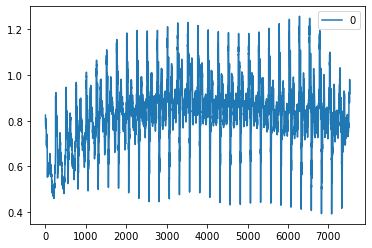

In [114]:
yhat.plot()

In [92]:
yhat = minmax.inverse_transform(yhat)
# yhat = pd.Dataframe(yhat)

ValueError: non-broadcastable output operand with shape (7530,1) doesn't match the broadcast shape (7530,412)

In [ ]:


plt.figure(figsize=(14,5))
plt.plot(training_data['CTXR'])
plt.plot(test_data['CTXR'])
plt.plot(yhat)
plt.title(f"{model_settings['symbol']} Price vs Predicted Price Movement")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price in USD")

# Trying another different appraoch below...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# settings
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 60, 'n_steps_out': 30, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")


# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [ ]:
# convert series to supervised learning
# honestly not sure I need this? may skip for now.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ...t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += 
    # forcase sequence
    for i in range(0, n_out):

In [3]:
# skipping to defining/fitting the model, but using the minmax scaler first
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_df.values)
scaled

array([[0.71568631, 0.19893428, 0.00884956, ..., 0.10026585, 0.71584037,
        0.50853241],
       [0.61437913, 0.1918295 , 0.00884956, ..., 0.10064564, 0.7339782 ,
        0.49658699],
       [0.57189544, 0.19597397, 0.00884956, ..., 0.09342954, 0.78839176,
        0.47781564],
       ...,
       [0.26307192, 0.08170516, 0.00274337, ..., 0.35624762, 0.28470376,
        0.38940271],
       [0.22385623, 0.07845472, 0.00176991, ..., 0.3205469 , 0.29183798,
        0.38907844],
       [0.23529413, 0.07815277, 0.0119469 , ..., 0.34170148, 0.34993953,
        0.41126276]])

In [4]:
scaled.shape

(360, 412)

In [5]:
# split data
# split into test/train data sets

# splitting test/training data
data_size = len(scaled)

# using a 90/10 train/test split
training_data = scaled[:(int(data_size * model_settings['train_test_ratio']))]
test_data = scaled[(int(data_size * model_settings['train_test_ratio'])):]

In [ ]:
# split into inputs, outputs
train_X, train_y = training_data[:, ]
# reshape inputs to be 3D for LSTM [samples, timesteps, features]
